# Information scrapping

In [382]:
!pip install umap-learn

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time

In [2]:
with open('/content/PMIDs_list.txt') as file:
    pmids = set([line.strip() for line in file])

In [3]:
elink_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"
params = {
    "dbfrom": "pubmed",
    "db": "gds",
    "id": ','.join(pmids),
    "retmode": "json"
}

# if api_key:
#     params["api_key"] = api_key

r = requests.get(elink_url, params=params).json()

geo_ids = r['linksets'][0]['linksetdbs'][0]['links']
len(geo_ids)

145

In [4]:
esummary_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"

params2 = {
        "db": "gds",
        "id": ','.join(geo_ids),
        "retmode": "json"
    }
r = requests.get(esummary_url, params=params2).json()

In [5]:
data = []
for geo_id in geo_ids:
    geo_info = r['result'][geo_id]
    gse_id = 'GSE' + geo_info['gse']
    title = 'Title: ' + geo_info['title']
    experiment_type = 'Experiment type: ' + geo_info['gdstype']
    summary = 'Summary: ' + geo_info['summary']
    organism = 'Organism: ' + geo_info['taxon']

    link = f'https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={gse_id}'
    response = requests.get(link)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        overall_design = 'Overall design: ' + '; '.join(soup.find("td", string="Overall design").find_next_sibling("td").stripped_strings)
    else:
        print(f"Failed to retrieve data from {link}")
        overall_design = 'Overall design: not fetched'

    contents = ' '.join([title, experiment_type, summary, organism, overall_design])

    relevant_pubmedids = [pubmedid for pubmedid in geo_info['pubmedids'] if pubmedid in pmids]
    data.append({
        'geo_id': geo_id,
        'gse_id': gse_id,
        'contents': contents,
        'pmids': relevant_pubmedids,
    })

df = pd.DataFrame(data)

In [6]:
df

,geo_id,gse_id,contents,pmids
0,200272793,GSE272793,Title: An atlas of small non-coding RNAs in Hu...,[39367016]
1,200268524,GSE268524,Title: A robust circulating microRNA signature...,[39838364]
2,200263013,GSE263013,Title: Repetitive element transcript accumulat...,[38641753]
3,200261729,GSE261729,Title: Investigating the transcriptional heter...,[39762647]
4,200254970,GSE254970,"Title: Age, Sex and Alzheimer’s disease: a lon...",[38909241]
...,...,...,...,...
140,200018126,GSE18126,Title: Methylation status in AG- and PG-derive...,[20385583]
141,200017554,GSE17554,Title: Nucleosome deposition and DNA methylati...,"[19723310, 20602769]"
142,200015745,GSE15745,Title: Abundant Quantitative Trait Loci for Cp...,[20485568]
143,200009990,GSE9990,Title: Transcriptional profiles of rodent hipp...,[19211887]


# TF-IDF vectorizing

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
contents = df.contents

In [9]:
import nltk
from nltk.tokenize import RegexpTokenizer
import nltk.data
nltk.download('stopwords')
import string

stopwords = set(nltk.corpus.stopwords.words('english'))
stop_set = stopwords | set(list(string.punctuation))
tokenizer = RegexpTokenizer(r'\w+')
stemmer = nltk.stem.SnowballStemmer('english')

def regexp_stemm_tokenize(text: str) -> list[str]:
    tokens = tokenizer.tokenize(text.lower())
    return [stemmer.stem(token) for token in tokens
            if token not in stop_set and len(token) > 1]

print(contents[0])
print(' '.join(regexp_stemm_tokenize(contents[0])))

Title: An atlas of small non-coding RNAs in Human Preimplantation Development (Mouse embryo RNA-seq) Experiment type: Expression profiling by high throughput sequencing Summary: Our current understanding of the molecular circuitries that govern early embryogenesis remains limited, particularly in the human. Small non-coding RNAs (sncRNAs) regulate gene expression transcriptionally and post-transcriptionally, however, the expression of specific biotypes and their dynamics during preimplantation development remains to be determined. Using Small-seq, we identified the abundance of and dynamic expression of piRNA, rRNA, snoRNA, tRNA, and miRNA in human embryos from day 3 to 7. Among the biotypes, both miRNA and snoRNA displayed distinct associations with developmental time and lineage formation, many of which were  found to target key gene expression programs in pluripotency and lineage establishment. We observed an enrichment of the chromosome 19 miRNA cluster (C19MC) in the trophectoderm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
contents_tokenized = [' '.join(regexp_stemm_tokenize(content)) for content in contents]

In [11]:
contents[0]

'Title: An atlas of small non-coding RNAs in Human Preimplantation Development (Mouse embryo RNA-seq) Experiment type: Expression profiling by high throughput sequencing Summary: Our current understanding of the molecular circuitries that govern early embryogenesis remains limited, particularly in the human. Small non-coding RNAs (sncRNAs) regulate gene expression transcriptionally and post-transcriptionally, however, the expression of specific biotypes and their dynamics during preimplantation development remains to be determined. Using Small-seq, we identified the abundance of and dynamic expression of piRNA, rRNA, snoRNA, tRNA, and miRNA in human embryos from day 3 to 7. Among the biotypes, both miRNA and snoRNA displayed distinct associations with developmental time and lineage formation, many of which were  found to target key gene expression programs in pluripotency and lineage establishment. We observed an enrichment of the chromosome 19 miRNA cluster (C19MC) in the trophectoder

In [12]:
contents_tokenized[0]

'titl atlas small non code rnas human preimplant develop mous embryo rna seq experi type express profil high throughput sequenc summari current understand molecular circuitri govern earli embryogenesi remain limit particular human small non code rnas sncrnas regul gene express transcript post transcript howev express specif biotyp dynam preimplant develop remain determin use small seq identifi abund dynam express pirna rrna snorna trna mirna human embryo day among biotyp mirna snorna display distinct associ development time lineag format mani found target key gene express program pluripot lineag establish observ enrich chromosom 19 mirna cluster c19mc trophectoderm te chromosom 14 mirna cluster c14mc meg8 relat snorna inner cell mass icm addit isomir analys suggest mirna modifi differenti blastul final six novel mirna embryo gene target identifi analys provid first comprehens measur sncrna biotyp correspond dynam throughout human preimplant develop provid extens resourc elucid function

In [36]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    max_df=0.9,
    min_df=5,
    # ngram_range=(1,3),
    stop_words='english',
)

In [81]:
vectors = vectorizer.fit_transform(contents_tokenized)
# vectors = vectorizer.fit_transform(contents)
print(f'Shape: {vectors.shape}')
print(f'Density: {vectors.nnz / np.prod(vectors.shape):.3f}')

Shape: (145, 636)
Density: 0.091


In [84]:
feature_names = vectorizer.get_feature_names_out()

# Clustering

In [85]:
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from umap import UMAP

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [86]:
labels = dict()
def dbscan_clustering(vectors, eps=0.5, min_samples=5, metric='cosine'):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(vectors)
    labels_db = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise_ = list(labels_db).count(-1)
    print(f"Estimated number of clusters: {n_clusters_}")
    print(f"Estimated number of noise points: {n_noise_}")
    if n_clusters_ > 1:
        print(f"Silhouette score: {silhouette_score(vectors, labels_db, metric='cosine'):.3f}")
    return labels_db

labels_db = dbscan_clustering(vectors, eps=0.5)
labels['db'] = labels_db

Estimated number of clusters: 6
Estimated number of noise points: 103
Silhouette score: 0.084


In [95]:
def hdbscan_clustering(vectors, min_cluster_size=8, min_samples=3, metric='cosine'):
    hdb = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric).fit(vectors)
    labels_hdb = hdb.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
    n_noise_ = list(labels_hdb).count(-1)

    print(f"Estimated number of clusters: {n_clusters_}")
    print(f"Estimated number of noise points: {n_noise_}")
    if n_clusters_ > 1:
        print(f"Silhouette score: {silhouette_score(vectors, labels_hdb, metric='cosine'):.3f}")
    return labels_hdb

labels_hdb = hdbscan_clustering(vectors, min_cluster_size=9, min_samples=3)
labels['hdb'] = labels_hdb

Estimated number of clusters: 3
Estimated number of noise points: 59
Silhouette score: 0.061


In [91]:
min_n = 145
for cl_size in range(2, 15):
    for samples_size in range(2, 15):
        n, labels_hdb = hdbscan_clustering(vectors, min_cluster_size=cl_size, min_samples=samples_size)
        if n < min_n:
            min_n = n
            min_cl_size = cl_size
            min_samples = samples_size
print(min_n, min_cl_size, min_samples)

37 11 2


In [116]:
min_n = 145
for eps in np.linspace(0.1, 1, 9, endpoint=False):
    for samples_size in range(2, 15):
        n_cl, n_noise, labels_db = dbscan_clustering(vectors, eps=eps, min_samples=samples_size)
        if n_noise < min_n and n_cl > 1:
            min_n = n_noise
            min_eps = eps
            min_samples = samples_size
print(min_n, min_eps, min_samples)

11 0.7000000000000001 2


In [53]:
def hierarchical_clustering(vectors, n_clusters=2, metric='cosine'):
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage='average')
    labels_hc = hc.fit_predict(vectors.toarray())
    if n_clusters > 1:
        print(f"Silhouette score: {silhouette_score(vectors, labels_hc, metric='cosine'):.3f}")
    return labels_hc

labels_hc = hierarchical_clustering(vectors, n_clusters=3)
labels['hc'] = labels_hc

Silhouette score: 0.052


In [54]:
def kmeans_clustering(vectors, n_clusters=2):
    vectors_n = normalize(vectors)
    labels_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10).fit_predict(vectors_n)
    return labels_kmeans

labels_kmeans = kmeans_clustering(vectors, n_clusters=2)
labels['kmeans'] = labels_kmeans

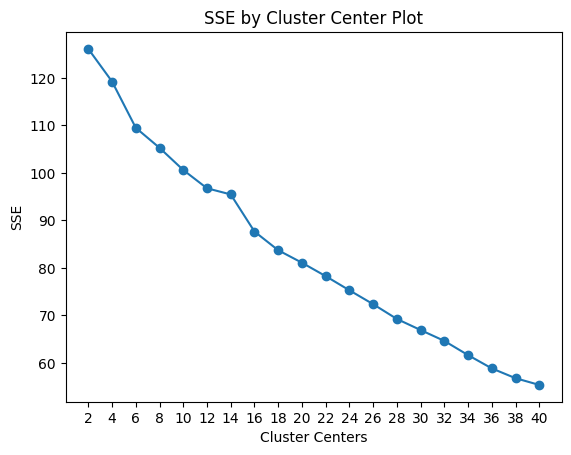

In [55]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)

    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=42).fit(data).inertia_)

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

vectors_n = normalize(vectors)
find_optimal_clusters(vectors_n, 40)

### Visualization functions

In [56]:
def visualize_data(vectors, dim=2, reduction_types=['svd', 'pca', 'tsne', 'umap']):

    """Visulization of data"""

    if not isinstance(reduction_types, list):
        raise TypeError("reduction_types must be a list")

    # Visualize the data
    if 'svd' in reduction_types:
        # Method 1: Using TruncatedSVD
        svd = TruncatedSVD(n_components=dim, random_state=42)
        vectors_svd = svd.fit_transform(vectors)

        # Visualize the SVD results
        if dim == 2:
            plt.figure()
            plt.scatter(vectors_svd[:, 0], vectors_svd[:, 1], alpha=0.5)
            plt.title('Document Vector Space (SVD)')
            plt.xlabel(f'Component 1 (explains {svd.explained_variance_ratio_[0]:.2%} of variance)')
            plt.ylabel(f'Component 2 (explains {svd.explained_variance_ratio_[1]:.2%} of variance)')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        elif dim == 3:
            fig = px.scatter_3d(vectors_svd, x=0, y=1, z=2)
            fig.update_traces(marker_size=6)
            fig.show()

        print(f"Total explained variance: {sum(svd.explained_variance_ratio_):.2%}")

    if 'pca' in reduction_types:
        # Method 2: Using PCA
        pca = PCA(n_components=dim)
        vectors_pca = pca.fit_transform(normalize(vectors))

        # Visualize the PCA results
        if dim == 2:
            plt.figure()
            plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], alpha=0.5)
            plt.title('Document Vector Space (PCA)')
            plt.xlabel(f'Component 1 (explains {pca.explained_variance_ratio_[0]:.2%} of variance)')
            plt.ylabel(f'Component 2 (explains {pca.explained_variance_ratio_[1]:.2%} of variance)')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        elif dim == 3:
            fig = px.scatter_3d(vectors_pca, x=0, y=1, z=2)
            fig.update_traces(marker_size=6)
            fig.show()
        print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

    if 'tsne' in reduction_types:
        # Method 3: t-SNE visualization
        # First reduce to intermediate dimensions with SVD
        svd_interim = TruncatedSVD(n_components=50, random_state=42)
        vectors_50d = svd_interim.fit_transform(vectors)

        # Then apply t-SNE
        tsne = TSNE(n_components=dim, perplexity=30, random_state=42, max_iter=1000)
        vectors_tsne = tsne.fit_transform(vectors_50d)

        # Visualize t-SNE results
        if dim == 2:
            plt.figure()
            plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], alpha=0.5)
            plt.title('Document Vector Space (t-SNE)')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        elif dim == 3:
            fig = px.scatter_3d(vectors_tsne, x=0, y=1, z=2)
            fig.update_traces(marker_size=6)
            fig.show()

    if 'umap' in reduction_types:
        # Method 4: UMAP visualization
        vectors_umap = UMAP(n_components=dim, init='random').fit_transform(vectors)

        # Visualize UMAP results
        if dim == 2:
            plt.figure()
            plt.scatter(vectors_umap[:, 0], vectors_umap[:, 1], alpha=0.5)
            plt.title('Document Vector Space (UMAP)')
            plt.xlabel('UMAP Component 1')
            plt.ylabel('UMAP Component 2')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        elif dim == 3:
            fig = px.scatter_3d(vectors_umap, x=0, y=1, z=2)
            fig.update_traces(marker_size=6)
            fig.show()

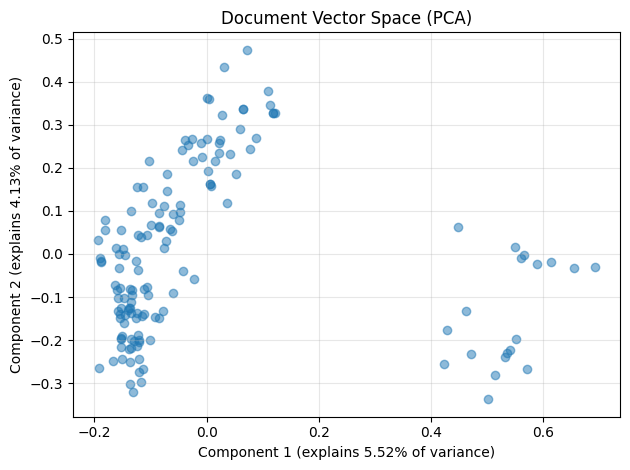

Total explained variance: 9.65%


In [60]:
visualize_data(vectors, 2, ['pca'])

In [98]:
def visualize_clustering(vectors, cluster_labels, dim=2, reduction_types=['svd', 'pca', 'tsne', 'umap']):

    """Visulization of clustered data"""

    if not isinstance(reduction_types, list):
        raise TypeError("reduction_types must be a list")

    # Visualize the data
    if 'svd' in reduction_types:
        # Method 1: Using TruncatedSVD
        svd = TruncatedSVD(n_components=dim, random_state=42)
        vectors_svd = svd.fit_transform(vectors)

        # Visualize the SVD results with cluster colors
        if dim == 2:
            fig, ax = plt.subplots()
            for cluster_id in np.unique(cluster_labels):
                mask = (cluster_labels == cluster_id)
                plt.scatter(
                    vectors_svd[mask, 0],
                    vectors_svd[mask, 1],
                    label=f'Cluster {cluster_id}',
                    alpha=0.7,
                    s=50,
                    edgecolors='w'
                )
            plt.title('2D Cluster Visualization with SVD reduction')
            plt.xlabel(f'Component 1 (explains {svd.explained_variance_ratio_[0]:.2%} of variance)')
            plt.ylabel(f'Component 2 (explains {svd.explained_variance_ratio_[1]:.2%} of variance)')
            plt.grid(alpha=0.3)
            plt.legend(title="Clusters", loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.show()
        elif dim == 3:
            fig = px.scatter_3d(
                vectors_svd,
                x=0, y=1, z=2,
                color=cluster_labels,
                labels={'color': 'Cluster'},
                title='3D Cluster Visualization with SVD reduction',
            )

            fig.update_traces(marker_size=6)
            fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))
            fig.show()
        print(f"Total explained variance: {sum(svd.explained_variance_ratio_):.2%}")

    if 'pca' in reduction_types:
        # Method 2: Using PCA
        pca = PCA(n_components=dim)
        vectors_pca = pca.fit_transform(vectors)

        # Visualize the PCA results with cluster colors
        if dim == 2:
            fig, ax = plt.subplots()
            for cluster_id in np.unique(cluster_labels):
                mask = (cluster_labels == cluster_id)
                plt.scatter(
                    vectors_pca[mask, 0],
                    vectors_pca[mask, 1],
                    label=f'Cluster {cluster_id}',
                    alpha=0.7,
                    s=50,
                    edgecolors='w'
                )
            plt.title('2D Cluster Visualization with PCA reduction')
            plt.xlabel(f'Component 1 (explains {pca.explained_variance_ratio_[0]:.2%} of variance)')
            plt.ylabel(f'Component 2 (explains {pca.explained_variance_ratio_[1]:.2%} of variance)')
            plt.grid(alpha=0.3)
            plt.legend(title="Clusters", loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.show()
        elif dim == 3:
            fig = px.scatter_3d(
                vectors_pca,
                x=0, y=1, z=2,
                color=cluster_labels,
                labels={'color': 'Cluster'},
                title='3D Cluster Visualization with PCA reduction'
            )

            fig.update_traces(marker_size=6)
            fig.show()

        print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

    if 'tsne' in reduction_types:
        # Method 3: t-SNE visualization with clusters
        # First reduce to intermediate dimensions with SVD
        svd_interim = TruncatedSVD(n_components=50, random_state=42)
        vectors_50d = svd_interim.fit_transform(vectors)

        # Then apply t-SNE
        tsne = TSNE(n_components=dim, perplexity=30, random_state=42, max_iter=1000)
        vectors_tsne = tsne.fit_transform(vectors_50d)

        # Visualize t-SNE results with cluster colors
        if dim == 2:
            fig, ax = plt.subplots()
            for cluster_id in np.unique(cluster_labels):
                mask = (cluster_labels == cluster_id)
                plt.scatter(
                    vectors_tsne[mask, 0],
                    vectors_tsne[mask, 1],
                    label=f'Cluster {cluster_id}',
                    alpha=0.7,
                    s=50,
                    edgecolors='w'
                )
            plt.title('2D Cluster Visualization with t-SNE reduction')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.grid(alpha=0.3)
            plt.legend(title="Clusters", loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.show()
        elif dim == 3:
            fig = px.scatter_3d(
                vectors_tsne,
                x=0, y=1, z=2,
                color=cluster_labels,
                labels={'color': 'Cluster'},
                title='3D Cluster Visualization with t-SNE reduction'
            )

            fig.update_traces(marker_size=6)
            fig.show()


    if 'umap' in reduction_types:
        # Method 4: UMAP visualization
        vectors_umap = UMAP(n_components=dim, init='random').fit_transform(vectors)

        # Visualize UMAP results
        if dim == 2:
            fig, ax = plt.subplots()
            for cluster_id in np.unique(cluster_labels):
                mask = (cluster_labels == cluster_id)
                plt.scatter(
                    vectors_umap[mask, 0],
                    vectors_umap[mask, 1],
                    label=f'Cluster {cluster_id}',
                    alpha=0.7,
                    s=50,
                    edgecolors='w'
                )
            plt.title('3D Cluster Visualization with UMAP reduction')
            plt.xlabel('UMAP Component 1')
            plt.ylabel('UMAP Component 2')
            plt.grid(alpha=0.3)
            plt.legend(title="Clusters", loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.show()
        elif dim == 3:
            fig = px.scatter_3d(
                vectors_umap,
                x=0, y=1, z=2,
                color=cluster_labels,
                labels={'color': 'Cluster'},
                title='3D Cluster Visualization with UMAP reduction'
            )

            fig.update_traces(marker_size=6)
            fig.show()

### Visualization

In [99]:
visualize_clustering(vectors, np.array(list(map(str, labels['hdb']))), 3, ['svd'])

Total explained variance: 10.42%


### Dimensionality reduction

In [76]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler

lsa = make_pipeline(TruncatedSVD(n_components=100))

vectors_lsa = lsa.fit_transform(vectors)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%\n")

labels_100d = dict()
labels_db_100d = dbscan_clustering(vectors_lsa, eps=0.5, min_samples=5, metric='cosine')
print()
labels_hdb_100d = hdbscan_clustering(vectors_lsa)
print()
labels_hc_100d = hierarchical_clustering(vectors, n_clusters=2)
labels_kmeans_100d = kmeans_clustering(vectors_lsa, n_clusters=2)

labels_lsa = {'db': labels_db_100d, 'hdb': labels_hdb_100d, 'kmeans': labels_kmeans_100d, 'hc': labels_hc_100d}

Explained variance of the SVD step: 96.1%

Estimated number of clusters: 5
Estimated number of noise points: 96
Silhouette score: 0.106

Estimated number of clusters: 2
Estimated number of noise points: 45
Silhouette score: 0.045

Silhouette score: 0.061


### Clustering Visualization

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



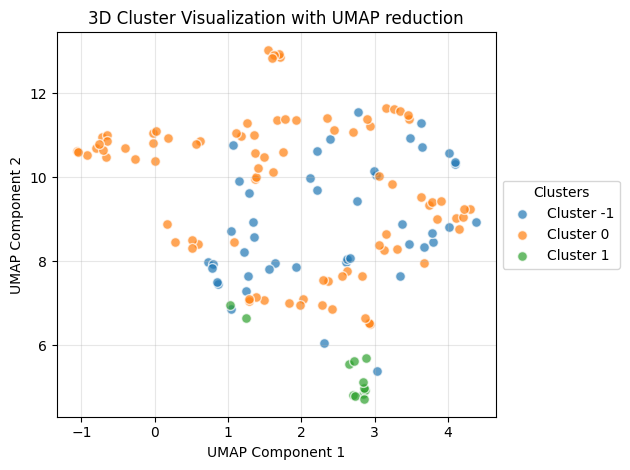

In [79]:
visualize_clustering(vectors, np.array(list(map(str, labels_lsa['hdb']))), 2, ['umap'])